# EDA - Smart vs Random
How does a smart warehouse configuration compare against random configurations
* Smart configuration - A warehouse configuration wherein high demand items are placed closer to the gate and vice versa
* Random configuration - Serves as the baseline to test the quality of any configuration, be it demand based or ones determined by GA

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from colorama import Fore, Style, init
import csv
import statistics
import math
import pandas as pd
import json
import random
import glob
import re

In [2]:
from classes.CellIterator import CellIterator
from classes.Item import Item
from classes.Worker import Worker
from classes.Warehouse import Warehouse

### Create the warehouses

In [3]:
NUM_BAYS = 6
RACK_LENGTH = 15
CELLS_PER_BAY = 20
CELL_LENGTH = RACK_LENGTH / CELLS_PER_BAY
RACK_WIDTH = 0.8
BAY_WIDTH = RACK_WIDTH / 2
LEVEL_HEIGHT = 0.2

WHR = Warehouse(
    NUM_BAYS,
    RACK_LENGTH,
    CELLS_PER_BAY,
    BAY_WIDTH,
    LEVEL_HEIGHT
)

WHS = Warehouse(
    NUM_BAYS,
    RACK_LENGTH,
    CELLS_PER_BAY,
    BAY_WIDTH,
    LEVEL_HEIGHT
)

## Datagen

In [4]:
def clear_directory(directory_path):
    # Ensure the directory exists
    if not os.path.isdir(directory_path):
        print(f"Directory {directory_path} does not exist.")
        return

    # Use glob to match all files in the directory
    files = glob.glob(os.path.join(directory_path, '*'))
    
    # Loop through and delete each file
    for file in files:
        try:
            os.remove(file)
            # print(f"Deleted {file}")
        except Exception as e:
            print(f"Error deleting file {file}: {e}")
            
def load_order_history(input_file):
    file_path = 'data/order_history_small.csv'
    items = []

    with open(file_path, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            items.append({
                "id": int(row["id"]),
                "name": row["name"],
                "quantity": int(row["quantity"]),
                "volume": int(row["volume"]),
                "cover": int(row["cover"])
            })

    total_quantity_6m = sum([item['quantity'] for item in items])
    item_probabilities = [item['quantity'] / total_quantity_6m for item in items]

    return items, item_probabilities

# Generate orders
def generate_orders(num_orders, items, item_probabilities):
    orders = []
    total_items = 0
    for _ in range(num_orders):
        num_items_in_order = random.randint(1, 5)  # Each order can have between 1 and 5 items
        order_items = random.choices(items, weights=item_probabilities, k=num_items_in_order)
        orders.append({"items": order_items})
    return orders

def gen_order_list(num_orders, file_num, items, item_probabilities):
    # Generate a list of orders
    orders = generate_orders(num_orders, items, item_probabilities)

    # Save the orders to a JSON file
    with open(f'data/orders/orders{file_num}.json', 'w') as json_file:
        json.dump(orders, json_file, indent=4)

def datagen(num_order_lists, sample_size):
    clear_directory("data/orders/")
    items, item_probabilities = load_order_history("data/order_history_small.csv")
    for file_num in range(num_order_lists):
        gen_order_list(sample_size, file_num, items, item_probabilities)

In [5]:

datagen(10, 3000)

### Utility Functions

In [6]:
def log_total_cells_to_csv(costs, file_path):
    # Ensure the directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Check if the file exists
    file_exists = os.path.isfile(file_path)
    
    # Open the file in append mode
    with open(file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        # If the file doesn't exist, write the header
        if not file_exists:
            headers = ['n'] + [f'cst{i+1}' for i in range(len(costs))] + ['avg', 'min', 'max', 'std', 'moe']
            writer.writerow(headers)

        # Get the trial number
        if file_exists:
            # Read the existing data to determine the trial number
            with open(file_path, mode='r') as read_file:
                reader = csv.reader(read_file)
                rows = list(reader)
                trial_number = len(rows)  # Assuming the header is included, this will give the next trial number
        else:
            trial_number = 1

        # Calculate average, minimum, maximum, and variance
        avg_cost = sum(costs) / len(costs)
        min_cost = min(costs)
        max_cost = max(costs)
        std_cost = round(math.sqrt(statistics.variance(costs)) if len(costs) > 1 else 0, 2)
        moe_cost = round(margin_of_error(std_cost, len(costs)), 2)

        # Write the new record
        writer.writerow([trial_number] + costs + [avg_cost, min_cost, max_cost, std_cost, moe_cost])

def margin_of_error(std_dev, sample_size, z_score=1.96):
    return z_score * (std_dev / math.sqrt(sample_size))

def delete_file(file):
    if os.path.exists(file):
        os.remove(file)
        # print(f"{file} has been deleted successfully.")
    else:
        print(f"{file} does not exist.")

### Generate cost metrics for a warehouse

In [7]:
def wms_runner(WH, type):
    WH.generate_item_list_small("./data/order_history_small.csv")
    
    # create a warehouse configuration (random / smart)
    if type == "random": WH.sprinkle_aisle()
    elif type == "smart": WH.smart_sprinkle()

    directory = 'data/orders'
    costs = []

    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if not os.path.isfile(file_path): continue

        WH.read_orders(file_path)
        WH.dist_batched_order_list()

        for worker in WH.workers: worker.min_max_order_list(WH.aisle_items)

        total_cells = 0
        for worker in WH.workers:
            worker.fulfill_batched_order()
            total_cells += worker.cells_travelled

        costs.append(total_cells)
        WH.reset("soft")

    if type == "random": log_total_cells_to_csv(costs, "results/wms-random.csv")
    if type == "smart": log_total_cells_to_csv(costs, "results/wms-smart.csv")

    WH.reset("hard")
    # print("Done!")

In [8]:
delete_file("results/wms-random.csv")
delete_file("results/wms-smart.csv")

In [9]:
WHS.reset(type="hard")
WHR.reset(type="hard")

N = 100
wms_runner(WHS, type="smart")
for _ in range(N):
    wms_runner(WHR, type="random")

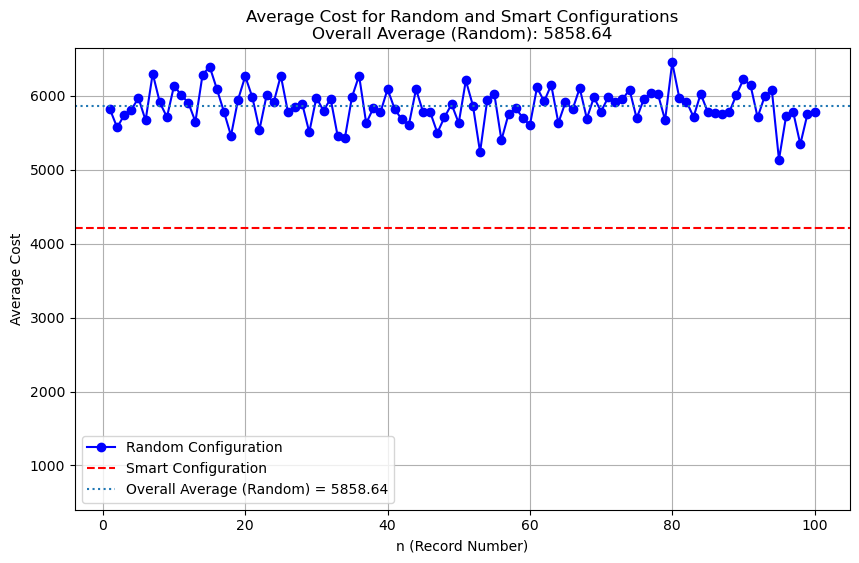

In [10]:
# Define the paths for the CSV files
results_path = "results/"
random_csv_path = os.path.join(results_path, "wms-random.csv")
smart_csv_path = os.path.join(results_path, "wms-smart.csv")

# Read the CSV files into DataFrames
df_random = pd.read_csv(random_csv_path)
df_smart = pd.read_csv(smart_csv_path)

# Extract the necessary columns
n_random = df_random['n']
avg_random = df_random['avg']

n_smart = df_smart['n']
avg_smart = df_smart['avg'].iloc[0]  # Since all records are the same, take the avg from the first record

# Calculate the overall average of the 'avg' column in df_random
overall_avg_random = df_random['avg'].mean()

# Plot the average cost for each record from both CSV files on the same graph
plt.figure(figsize=(10, 6))

plt.plot(n_random, avg_random, label='Random Configuration', marker='o', linestyle='-', color='b')
plt.axhline(y=avg_smart, label='Smart Configuration', color='r', linestyle='--')
plt.axhline(y=overall_avg_random, label=f'Overall Average (Random) = {overall_avg_random:.2f}', color='#1f77b4', linestyle=':')

plt.xlabel('n (Record Number)')
plt.ylabel('Average Cost')
plt.title(f'Average Cost for Random and Smart Configurations\nOverall Average (Random): {overall_avg_random:.2f}')
plt.legend()
plt.grid(True)

# Set the y-axis limit to ensure the baseline is on the top side
plt.ylim([400, df_random['avg'].max() + 200, ])

plt.show()


## Remarks

In [11]:
print(f"Random config cost: {overall_avg_random}")
print(f"Smart config cost: {avg_smart}")
print()

delta = overall_avg_random - avg_smart
print(f"Random configs cost more than smart configs")
print(f"Delta: {delta:.2f}")
print(f"Excess: {((delta / avg_smart) * 100):.2f}%")

Random config cost: 5858.635
Smart config cost: 4213.1

Random configs cost more than smart configs
Delta: 1645.53
Excess: 39.06%


Num orders
* (40, 100) - 410, 38%
* (20, 100) - 412, 40%
* (20, 50)  - 215, 42%
* (20, 200) - 834, 40%

In [74]:
def natural_sort_key(s):
    """ Sort strings with numbers in a natural order. """
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

In [98]:
def deltaplot(results_path, type):
    # Prepare the plot
    plt.figure(figsize=(12, 8))
    colors = ['black', 'orange', 'blue', 'yellow']
    
    # Iterate over each file in the directory
    random_directory = os.path.join(results_path, "wms-random/")
    smart_directory = os.path.join(results_path, "wms-smart/")

    random_files = os.listdir(random_directory)
    smart_files = os.listdir(smart_directory)

    random_files.sort(key=natural_sort_key)
    smart_files.sort(key=natural_sort_key)

    # [tuple(random cost, smart cost), ...]
    avg_costs = []
    print("random dir = ", random_directory)

    for i in range(len(os.listdir(random_directory))):
        random_file = random_directory + random_files[i]
        smart_file = smart_directory + smart_files[i]


        random_filename = random_file[len(random_directory):]
        smart_filename = smart_file[len(smart_directory):]

        order_size = int(random_filename[:-4])
        norm_factor = order_size


        if not (os.path.isfile(random_file) and random_file.endswith('.csv')): continue
        if not (os.path.isfile(smart_file) and smart_file.endswith('.csv')): continue

        # Read the CSV file into a DataFrame
        df_random = pd.read_csv(random_file)
        df_smart = pd.read_csv(smart_file)
        
        # Extract the necessary columns
        n_random = df_random['n']
        avg_random = df_random['avg']
        overall_avg_random = df_random['avg'].mean() / norm_factor

        n_smart = df_smart['n']
        avg_smart = df_smart['avg']
        overall_avg_smart = df_smart['avg'].mean() / norm_factor

        avg_costs.append((overall_avg_random, overall_avg_smart))

        print("overall avg random = ", overall_avg_random)
        

        if type == "all": plt.plot(n_random, avg_random, label=f'Random Configuration {random_filename}', color=colors[i], marker='.', linestyle='-')
        if type == "avg": plt.axhline(y=overall_avg_random, label=f'Random Config Avg {random_filename}', color=colors[i], linestyle='--')

        if type == "all": plt.plot(n_smart, avg_smart, label=f'Smart Configuration {smart_filename}', color=colors[i], marker='.', linestyle='-')
        if type == "avg": plt.axhline(y=overall_avg_smart, label=f'Smart Config Avg {smart_filename}', color=colors[i], linestyle='--')



    # Customize the plot
    plt.xlabel('n (Record Number)')
    plt.ylabel('Average Cost')
    plt.title('Average Cost for Random and Smart Configurations')
    plt.legend()
    plt.grid(True)
    plt.ylim([0, 8000])

    # Show the plot
    plt.show()
    return avg_costs


random dir =  results/wms-random/
overall avg random =  2100.234
overall avg random =  809.5267499999999
overall avg random =  503.6964285714285
overall avg random =  363.9652


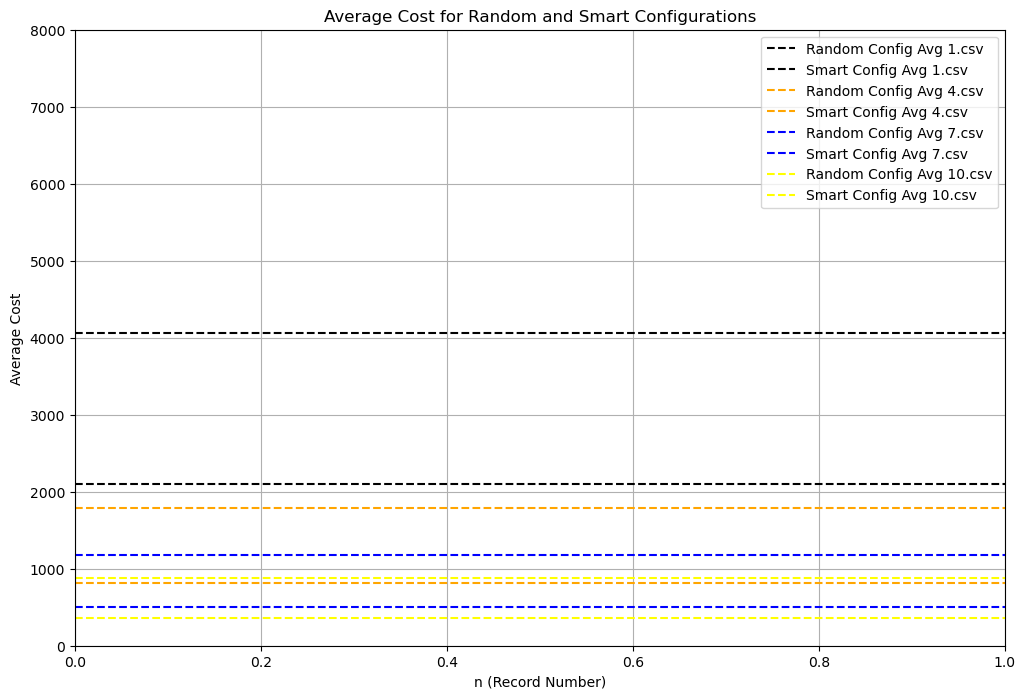

In [99]:
# Example usage
results_path = "results/"
avg_costs = deltaplot(results_path, type="avg")

In [100]:
avg_costs

[(2100.234, 4067.2),
 (809.5267499999999, 1792.65),
 (503.6964285714285, 1180.185714285714),
 (363.9652, 877.32)]

In [103]:
def deltaplot_bar(avg_costs):
    # Number of tuples
    n_groups = len(avg_costs)

    # Separate the tuples into two lists for easier plotting
    first_values = [item[1] for item in avg_costs]
    second_values = [item[0] for item in avg_costs]
    deltas = [item[1] - item[0] for item in avg_costs]

    # Bar width
    bar_width = 0.2
    gap_width = 0.5  # Width of the gap between groups

    # Positions of the bars on the x-axis
    index = np.arange(n_groups) * (3 * bar_width + gap_width)  # Adjust positions to include gaps

    # Create the plot
    fig, ax = plt.subplots()

    bars1 = ax.bar(index, first_values, bar_width, label='Smart Cost', color='black')
    bars2 = ax.bar(index + bar_width, second_values, bar_width, label='Random Cost', color='gray')
    # bars3 = ax.bar(index + 2 * bar_width, deltas, bar_width, label='Delta', color='#00AAAA')

    # Add labels, title, and custom x-axis tick labels
    ax.set_xlabel('Order Size')
    ax.set_ylabel('Cost')
    ax.set_title('Costs by group and type')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels([1, 4, 7, 10])  # Update the x-axis labels to your desired labels
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
    return deltas


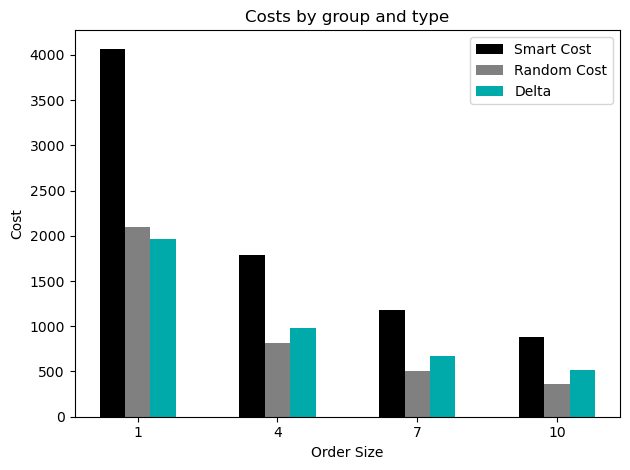

In [104]:
deltas = deltaplot_bar(avg_costs)

In [107]:
print(deltas)
print(deltas[1] / deltas[0])
print(deltas[2] / deltas[0])
print(deltas[3] / deltas[0])

[1966.966, 983.1232500000002, 676.4892857142856, 513.3548000000001]
0.4998171041085612
0.3439252563157094
0.26098814112699464
